<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/classification/animals/Animal_classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal classifier

## Setup and imports



In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!rm -rf /content/*
!wget --no-check-certificate -O dataset.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228202&authkey=ADau7jkkCZLnQ8k"
!unzip -q dataset.zip

--2020-02-23 12:09:52--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228202&authkey=ADau7jkkCZLnQ8k
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://kusdwq.am.files.1drv.com/y4mzw_fgVcyw7M7GfEa2Jv0jtomW9FWM19N6wEnzdudyARCJk27OmbrFdHnzQ6KTOX5cVj8PujK7XcdVuEXbZBqHYp-wSte_zubIKg7cC1JFnY1Rzt3RzIW9Hju1lp5875HTGWWlFf0rq6UgfL7CB5Pc9Pmr2CqtZeYBaQBATEpKdxUNAqCGF_fJltuQaK6uMJ4UUPRZAlXmr5y3B_1Htl8aQ/images_160x120_downsampled.zip?download&psid=1 [following]
--2020-02-23 12:09:53--  https://kusdwq.am.files.1drv.com/y4mzw_fgVcyw7M7GfEa2Jv0jtomW9FWM19N6wEnzdudyARCJk27OmbrFdHnzQ6KTOX5cVj8PujK7XcdVuEXbZBqHYp-wSte_zubIKg7cC1JFnY1Rzt3RzIW9Hju1lp5875HTGWWlFf0rq6UgfL7CB5Pc9Pmr2CqtZeYBaQBATEpKdxUNAqCGF_fJltuQaK6uMJ4UUPRZAlXmr5y3B_1Htl8aQ/images_160x120_downsampled.zip?download&psid=1
Resolving kusdwq.am.fi

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()
import os
from os import listdir
from os.path import isdir, join
import shutil
from tqdm import tqdm
from datetime import datetime

from itertools import count
from collections import defaultdict

## Pre-process dataset

In [0]:
whitelist = [
    "pony",
    "alpaca",
    "chicken",
    "peacock",
    # "rabbit",
    "cat",
    # "pretty-chicken",
]

configurations = {
    "train": lambda fname: fname.split("_")[1] == "single" and fname.split("_")[0] in whitelist,
    "test": lambda fname: fname.split("_")[1] != "single" and fname.split("_")[0] in whitelist,
    "train_augmented": lambda fname: fname.split("_")[0] != "human",
    "test_augmented": lambda fname: fname.split("_")[1] != "human",
}


def generate_metadata(config, root="images", channel_prefix=True):
    """ Generates labels to be read by model data loader """

    classes = [c for c in listdir(root) if isdir(join(root, c))]
    samples = {c: 0 for c in classes}
    
    with open(f"labels_{config}.txt", "w") as f:
        for c in classes:
            batches = [b for b in listdir(join(root, c)) if isdir(join(root, c, b)) and configurations[config](b)]
            
            for b in batches:
                lwir_images = [i for i in listdir(join(root, c, b, "lwir")) if i.endswith(".png")]
                rgb_images = ["rgb_" + i[4:] for i in lwir_images] if channel_prefix else [i for i in lwir_images]

                lwir_paths = [join(root, c, b, "lwir", i) for i in lwir_images]
                rgb_paths = [join(root, c, b, "rgb", i) for i in rgb_images]

                for lwir_path, rgb_path in zip(lwir_paths, rgb_paths):
                    f.write(" ".join([rgb_path, lwir_path, c]) + "\n")
                    samples[c] += 1

    print("Dataset composition:")
    sum_ = 0
    for c, s in samples.items():
        sum_ += s
        print(f" - {c}: \t{s}")
    print(f"{sum_} items total.")


In [0]:
def save(path, name, rgb, lwir, label, extension=""):
    rgb_path = os.path.join(path, "rgb", name + f"_{extension}.png")
    lwir_path = os.path.join(path, "lwir", name + f"_{extension}.png")

    cv2.imwrite(rgb_path, rgb)
    cv2.imwrite(lwir_path, lwir)
    return " ".join([rgb_path, lwir_path, label])


def augment_dataset(metadata, augmented_dir, multiplier=2):

    if os.path.exists(augmented_dir):
        shutil.rmtree(augmented_dir)

    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=30,
        zoom_range=[0.5, 1],
    )

    classes = dict()
    samples = list()

    # Load labels
    with open(metadata, "r") as f:
        for line in f:
            line = line.split()
            samples.append(line)

            classes[line[-1]] = classes.get(line[-1], 0) + 1

    # Get maximum class samples
    max_class = max(classes.items(), key=lambda x: x[1])
    class_multipliers = {x: max_class[1] * multiplier // y for x, y in classes.items()}
    class_remainders = {x: (max_class[1] * multiplier) % y for x, y in classes.items()}

    # Generate output directory structure
    for label in classes:
        os.makedirs(os.path.join(augmented_dir, label, f"{label}_single_1", "lwir"))
        os.makedirs(os.path.join(augmented_dir, label, f"{label}_single_1", "rgb"))

    # Augment and copy
    augmented_samples = []
    for rgb_path, lwir_path, label in tqdm(samples, position=0):
        rgb = cv2.imread(rgb_path)
        lwir = cv2.imread(lwir_path)

        name = (rgb_path.split("/")[-1]).split(".")[0][4:]
        out_path = os.path.join(augmented_dir, label, f"{label}_single_1")

        # Copy original
        augmented_samples.append(save(out_path, name, rgb, lwir, label, extension=""))

        # Flipped
        rgb_t = datagen.apply_transform(rgb, {"flip_horizontal": True})
        lwir_t = datagen.apply_transform(lwir, {"flip_horizontal": True})

        augmented_samples.append(save(out_path, name, rgb_t, lwir_t, label, extension=0))

        # Random transformations
        remainder = 1 if class_remainders[label] > 0 else 0
        class_remainders[label] -= 1
        for i in range(2, class_multipliers[label] + remainder):
            trans = datagen.get_random_transform(rgb.shape)
            rgb_t = datagen.apply_transform(rgb, trans)
            lwir_t = datagen.apply_transform(lwir, trans)

            augmented_samples.append(save(out_path, name, rgb_t, lwir_t, label, extension=i))


    with open("augmented.txt", "w") as f:
        for line in augmented_samples:
            f.write(line + "\n")

In [0]:
generate_metadata("train", root="images_160x120_downsampled")
generate_metadata("test", root="images_160x120_downsampled")

Dataset composition:
 - pony: 	96
 - ugly-duck: 	0
 - alpaca: 	45
 - chicken: 	86
 - peacock: 	91
 - evil-chicken: 	0
 - rabbit: 	0
 - pig: 	0
 - ferret: 	0
 - human: 	0
 - cat: 	149
 - goose: 	0
 - pretty-chicken: 	0
 - sheep: 	0
467 items total.
Dataset composition:
 - pony: 	16
 - ugly-duck: 	0
 - alpaca: 	40
 - chicken: 	52
 - peacock: 	66
 - evil-chicken: 	0
 - rabbit: 	0
 - pig: 	0
 - ferret: 	0
 - human: 	0
 - cat: 	56
 - goose: 	0
 - pretty-chicken: 	0
 - sheep: 	0
230 items total.


In [0]:
augment_dataset("labels_train.txt", "train_images", multiplier=6)
print("\nTraining dataset")
generate_metadata("train_augmented", root="train_images", channel_prefix=False)

100%|██████████| 467/467 [00:39<00:00, 11.69it/s]



Training dataset
Dataset composition:
 - pony: 	894
 - alpaca: 	894
 - chicken: 	894
 - peacock: 	894
 - cat: 	894
4470 items total.


In [0]:
augment_dataset("labels_test.txt", "test_images", multiplier=2)
print("\nTesting dataset")
generate_metadata("test_augmented", root="test_images", channel_prefix=False)

100%|██████████| 230/230 [00:03<00:00, 68.11it/s] 


Testing dataset
Dataset composition:
 - pony: 	132
 - alpaca: 	132
 - chicken: 	132
 - peacock: 	132
 - cat: 	132
660 items total.


## Dataset

In [0]:
transformation = np.array([
    [1.202290, -0.026808, -50.528589],
    [0.017762, 1.203090, -73.950204],
])

class Dataset(K.utils.Sequence):

    def __init__(self, metadata, rgb_only=False, res=(480, 640), register=True, batch_size=16, split=False, train=True):

        self.rgb_only = rgb_only
        self.res = res
        self.register = register
        self.batch_size = batch_size

        self.classes = defaultdict(count().__next__)
        self.samples = []

        samples = []
        labels = []
        with open(metadata, "r") as f:
            for line in f:
                line = line.split()
                class_label = self.classes[line[-1]]
                samples.append(tuple(line[:2] + [class_label]))
                labels.append(class_label)

        if split:
            train_data, test_data = train_test_split(samples, stratify=labels, test_size=0.2, random_state=42)
            self.samples = train_data if train else test_data
        else:
            self.samples = samples

        self.class_dict = {key: val for val, key in self.classes.items()}
        self.class_labels = [val for key, val in sorted(self.class_dict.items())]

    def __len__(self):
        return len(self.samples) // self.batch_size
    

    def __iter__(self):
        return self


    def load(self, path, register=False):
        img = cv2.imread(path) / 255
        if register:
            img = cv2.resize(img, (480, 640))
            img = cv2.warpAffine(img, transformation, (480, 640))
        img = cv2.resize(img, self.res)
        return img


    def __getitem__(self, idx):
        if idx < self.__len__():
            X = []
            y = []
            for i in range(self.batch_size):
                rgb_path, lwir_path, label = self.samples[idx * self.batch_size + i]

                one_hot = np.zeros(self.num_classes())
                one_hot[label] = 1
                y.append(one_hot)

                rgb = self.load(rgb_path, register=self.register)

                if self.rgb_only:
                    X.append(rgb)
                else:
                    lwir = self.load(lwir_path, register=False)
                    lwir = np.mean(lwir, -1)[..., None]
                    stacked = np.dstack([rgb, lwir])
                    X.append(stacked)

            return np.array(X), np.array(y), [None]
        else:
            raise StopIteration

    def get_labels(self):
        return np.array([sample[-1] for sample in self.samples])

    def num_classes(self):
        return len(self.classes)

    def shape(self):
        return self.res[::-1] + tuple([(3 if self.rgb_only else 4)])


train_data = Dataset(f"labels_train_augmented.txt", rgb_only=False, split=False, res=(120, 160))
test_data = Dataset(f"labels_test_augmented.txt", rgb_only=False, split=False, res=(120, 160))

# train_data = Dataset(f"labels_train_augmented.txt", rgb_only=False, split=False, res=(120, 160))
# test_data = Dataset(f"labels_train_augmented.txt", rgb_only=False, split=False, res=(120, 160))

In [0]:
X, y, _ = train_data[0]
print(X.shape)

X, y, _ = test_data[0]
print(X.shape)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# ax1.imshow(X[i, ..., 0], cmap="gray")
# ax2.imshow(y_train[i, ..., 0], cmap="gray")

(16, 160, 120, 4)
(16, 160, 120, 4)


In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Keras model

## ResNet

In [0]:
class ResidualBlock(K.layers.Layer):
    
    def __init__(self, kernel_size=3, **kwargs):
        self.kernel_size = kernel_size
        super(ResidualBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv1 = K.layers.Conv2D(filters=input_shape[-1], kernel_size=(1, 1), strides=1, padding="same")
        self.conv2 = K.layers.Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, strides=1, padding="same")
        self.batch_norm1 = K.layers.BatchNormalization()
        self.batch_norm2 = K.layers.BatchNormalization()
        self.activation = K.layers.ReLU()
        self.add = K.layers.Add()
        # self.dropout = K.layers.Dropout(0.4)

        super(ResidualBlock, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        x_shortcut = x
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.add([x_shortcut, x])
        return x

    def compute_output_shape(self, input_shape):
        # return (input_shape[0], input_shape[1], input_shape[2], self.output_dim)
        return input_shape

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=train_data.shape()))

model.add(K.layers.AvgPool2D(pool_size=2))

model.add(K.layers.Conv2D(filters=32, kernel_size=7, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

model.add(ResidualBlock(kernel_size=3))
model.add(ResidualBlock(kernel_size=3))
model.add(ResidualBlock(kernel_size=3))

model.add(K.layers.Conv2D(filters=64, kernel_size=7, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

# model.add(ResidualBlock(kernel_size=3))
# model.add(ResidualBlock(kernel_size=3))
# model.add(ResidualBlock(kernel_size=3))

# model.add(K.layers.Conv2D(filters=256, kernel_size=7, strides=2, activation="relu", padding="valid"))
# model.add(K.layers.MaxPool2D(pool_size=2))

# model.add(ResidualBlock(kernel_size=3))
# model.add(ResidualBlock(kernel_size=3))
# model.add(ResidualBlock(kernel_size=3))



# model.add(K.layers.Conv2D(filters=8, kernel_size=5, strides=2, activation="relu", padding="same"))
# model.add(K.layers.Dropout(0.4))

# model.add(ResidualBlock())
# model.add(ResidualBlock())
# model.add(ResidualBlock())
# model.add(ResidualBlock())

# model.add(K.layers.Conv2D(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"))
# model.add(K.layers.MaxPool2D(pool_size=2))
# model.add(K.layers.Dropout(0.4))

# # model.add(ResidualBlock())
# # model.add(ResidualBlock())
# # model.add(ResidualBlock())
# # model.add(ResidualBlock())

# model.add(K.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same"))
# model.add(K.layers.MaxPool2D(pool_size=2))
# model.add(K.layers.Dropout(0.4))

# model.add(K.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same"))
# model.add(K.layers.MaxPool2D(pool_size=2))
# model.add(K.layers.Dropout(0.4))

model.add(K.layers.Flatten())
model.add(K.layers.Dense(train_data.num_classes(), activation="softmax"))

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_3 (Average (None, 80, 60, 4)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 37, 27, 32)        6304      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
residual_block_9 (ResidualBl (None, 18, 13, 32)        10560     
_________________________________________________________________
residual_block_10 (ResidualB (None, 18, 13, 32)        10560     
_________________________________________________________________
residual_block_11 (ResidualB (None, 18, 13, 32)        10560     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 4, 64)         

## StuffNet

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=train_data.shape()))

model.add(K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=11, strides=3))
model.add(K.layers.Dropout(0.4))

# Convolution 2
model.add(K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=5, strides=2))
model.add(K.layers.Dropout(0.4))

# Convolution 3
# model.add(K.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="valid"))
# model.add(K.layers.LeakyReLU())
# model.add(K.layers.MaxPool2D(pool_size=4, strides=2))
# model.add(K.layers.Dropout(0.4))

# Flatten for fully connected
model.add(K.layers.Flatten())

# Fully connected 4
model.add(K.layers.Dense(64, activation="relu"))
model.add(K.layers.Dropout(0.4))

# Output layer
model.add(K.layers.Dense(train_data.num_classes(), activation="sigmoid"))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 160, 120, 16)      592       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 75, 55, 16)        30992     
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 75, 55, 16)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 22, 15, 16)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 22, 15, 16)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 22, 15, 32)        4640      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 8, 5, 32)        

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=train_data.shape()))

model.add(K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=5, strides=2))
model.add(K.layers.Dropout(0.4))

# Convolution 2
model.add(K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=5, strides=1))
model.add(K.layers.Dropout(0.4))

# Convolution 3
model.add(K.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=5, strides=1))
model.add(K.layers.Dropout(0.4))

# Flatten for fully connected
model.add(K.layers.Flatten())

# Fully connected 4
model.add(K.layers.Dense(64, activation="relu"))
model.add(K.layers.Dropout(0.4))

# Output layer
model.add(K.layers.Dense(train_data.num_classes(), activation="sigmoid"))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 160, 120, 16)      592       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 80, 60, 16)        2320      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 80, 60, 16)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 38, 28, 16)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 38, 28, 16)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 38, 28, 32)        4640      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 19, 14, 32)      

## Train

In [0]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit

In [0]:
%%time
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

# model.fit(train_data, epochs=10, callbacks=[tensorboard_callback], validation_data=test_data)

model.fit(train_data, epochs=20, validation_data=test_data)

Train for 279 steps, validate for 41 steps
Epoch 1/20
279/279 [==============================] - 35s 125ms/step - loss: 1.5312 - accuracy: 0.2724 - val_loss: 1.3221 - val_accuracy: 0.4787
Epoch 2/20
279/279 [==============================] - 33s 120ms/step - loss: 1.2228 - accuracy: 0.4485 - val_loss: 1.1291 - val_accuracy: 0.4527
Epoch 3/20
279/279 [==============================] - 33s 120ms/step - loss: 1.0604 - accuracy: 0.5002 - val_loss: 1.1794 - val_accuracy: 0.4070
Epoch 4/20
279/279 [==============================] - 33s 120ms/step - loss: 0.9609 - accuracy: 0.5645 - val_loss: 1.2249 - val_accuracy: 0.3963
Epoch 5/20
279/279 [==============================] - 33s 119ms/step - loss: 0.8549 - accuracy: 0.6478 - val_loss: 1.3120 - val_accuracy: 0.5335
Epoch 6/20
279/279 [==============================] - 34s 120ms/step - loss: 0.9257 - accuracy: 0.6599 - val_loss: 1.3836 - val_accuracy: 0.5579
Epoch 7/20
279/279 [==============================] - 34s 121ms/step - loss: 0.7509 - a

In [0]:
model.save_weights('weights.h5')

In [0]:
model.load_weights("weights.h5")

In [0]:
y_pred = np.argmax(model.predict(test_data), axis=1)
y_test = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test, y_pred, target_names=test_data.class_labels))

              precision    recall  f1-score   support

        pony       0.57      0.85      0.68       132
      alpaca       0.40      0.11      0.17       132
     chicken       0.25      0.03      0.05       132
     peacock       0.41      0.75      0.53       132
         cat       0.77      1.00      0.87       128

    accuracy                           0.54       656
   macro avg       0.48      0.55      0.46       656
weighted avg       0.48      0.54      0.46       656



In [0]:
# test_data.get_labels().shape
# np.argmax(y_pred, axis=1).shape

(1124,)

In [0]:
print("Pred:", np.bincount(y_pred))
print("True:", np.bincount(y_test))

Pred: [118  65  94 235 144]
True: [132 132 132 132 128]


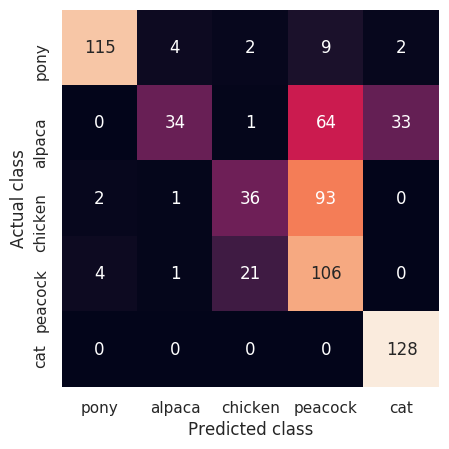

In [0]:
# y_pred = model.predict_classes(X_test)

y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
plt.show()

In [0]:
n = 5

ids = np.random.randint(0, len(test_data)-1, size=n)
preds = model.predict_classes(test_data[ids])

fig, axes = plt.subplots(1, n, figsize=(15, 10))

for id_, ax, pred in zip(ids, axes, preds):
    ax.imshow(X_test[id_][..., 1:])
    ax.axis('off')
    ax.set_title(data.class_labels[pred])

plt.tight_layout()

ValueError: ignored

defaultdict(<method-wrapper '__next__' of itertools.count object at 0x7f3ea2c8f6c8>,
            {'alpaca': 2, 'chicken': 4, 'peacock': 3, 'pig': 0, 'pony': 1})